<a href="https://colab.research.google.com/github/AlkaidCheng/GSoC2021_QMLHEP/blob/main/notebooks/TaskIV_GraphNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task IV - Graph Neural Network (GNN)


In [1]:
if 'google.colab' in str(get_ipython()):
  # install packages needed for this task
  !pip install dgl

# 1. Introduction

### Goal

- Perform Quark/Gluon jet classification on ParticleNet’s data for using Graph Neural Network (GNN)

### On the packages used

- In this task, we wil be using the `dgl` (deep graph library) package for constructing GNN models

In [2]:
# load some basic packages first
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# 2. Create Graph Representation of Data

References:

How to create a graph  https://docs.dgl.ai/tutorials/basics/1_first.html

How to assign features to edges:  https://docs.dgl.ai/guide/training-edge.html

### Load Data

The dataset contains:

- 50k quark and 50k gluons with constitutes (charged or neural tracks) of the jets

- Each jet is represented by a four-dimensional vector: $p_T, y, \phi$, and PDGid. 

In [3]:
if 'google.colab' in str(get_ipython()):
  !wget https://zenodo.org/record/3164691/files/QG_jets.npz

--2021-03-24 20:24:55--  https://zenodo.org/record/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz.5’

QG_jets.npz.5       100%[===================>] 101.75M  5.72MB/s    in 16s     

2021-03-24 20:25:12 (6.19 MB/s) - ‘QG_jets.npz.5’ saved [106689379/106689379]



In [4]:
data = dict(np.load('QG_jets.npz', allow_pickle=True))
X, y = data['X'], {'label': torch.tensor(data['y']).long()}
print('Dimension of input data: {}'.format(X.shape))

Dimension of input data: (100000, 139, 4)


### Create Graph Representation of Data

A graph can have features in three different places or levels:

- features for nodes
- features for edges
- features for the whole graph

A **jet** is **encoded as a graph**.

The **label** of whether it is a quark or a gluon is **encoded as the graph feature**.

Each constitute (**track**) is encoded as a **node** of the graph, with the **four-dimensional vector** as its **node features**.

Features are preprocessed to reflect a centred jets and normalised $p_T$ according to Eqn 3.1 of the original paper (https://arxiv.org/abs/1810.05165).

**Nodes** are **connected by bi-directional edges** if they are **adjacent** in either $p_T, y, \phi$.

This ensures that each graph is connected.

**Nodes index** are **ordered in descending order of $p_T$**.

In [5]:
import dgl
import networkx as nx
from dgl.data.utils import save_graphs, load_graphs

# https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

class GenerateGraphs(object):
    def describe(self): return self.__class__.__name__
    def __init__(self, data, connect_style):
        '''
          Args:
            data: np.ndarry
              input data
            connect_style: str
              Type of edge connections
        '''
        self.data = data
        self.label_name = 'label'
        self.feature_name = 'feature'
        self.connect_style = connect_style
        self._current_data = None

    def _assign_node_feature(self, graph):
        ''' Each node presents a b-jet with four momentum and b-tagging score as features.
        '''
        feature_name = 'feature'
        assert(self._current_data is not None)
        graph.ndata[feature_name] = torch.tensor(self._current_data)
        return graph

    def _create_graph(self, ievent: int):
        ''' Create a graph from a jet X [track multiplicity, "4-momentum"], where "4-momentum" is pt, rapidity, azimuthal angle, and pdgid.
            data: https://zenodo.org/record/3164691#.YFeQey1Q0lp
        '''
        self._current_data = self.data[ievent][~np.all(self.data[ievent] == 0, axis=1)]

        ''' Feature preprocessing: Sect 3.1 in https://arxiv.org/pdf/1810.05165.pdf
            centering jets and normalizing pT
            https://energyflow.network/examples/
        '''
        yphi_avg = np.average(self._current_data[:,1:3], weights=self._current_data[:,0], axis=0)
        self._current_data[:,1:3] -= yphi_avg
        self._current_data[:, 0] /= np.sum(self._current_data[:, 0])

        ''' - Sort by pT (0th column) '''
        self._current_data = self._current_data[self._current_data[:,0].argsort()][::-1].copy()

        ''' Construct a graph '''
        n_nodes = self._current_data.shape[0] # track multiplicity
        if self.connect_style == 'bifully':
            ''' Option 1: Fully connected graph '''
            g = nx.complete_graph(n_nodes)
            graph = dgl.from_networkx(g)
        else:
            ''' Option 2: Bi-directional connection in adjacent track in pT or eta or phi'''
            pt_order = self._current_data[:,0].argsort()[::-1]
            rapidity_order = self._current_data[:,1].argsort()[::-1]
            eta_order = self._current_data[:,2].argsort()[::-1]

            if self.connect_style == 'biadj_pt_y_phi':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_pt_y':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ]))
            elif self.connect_style == 'biadj_pt_phi':
                in_node  = np.concatenate((pt_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_y_phi':
                in_node  = np.concatenate((rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((rapidity_order[1: ], eta_order[1: ]))

            g = dgl.graph(( in_node, out_node), num_nodes=n_nodes)
            g = dgl.add_reverse_edges(g)
            graph = dgl.add_self_loop(g)


        ''' Assign node feature using "current data" '''
        graph = self._assign_node_feature(graph)

        return graph.int() # 32-bit integers for node and edge IDs to reduce memory

    def create_graphs(self, stop=None):
        ''' Create all graphs for all events.
        '''

        ''' PDGid to small float dictionary https://github.com/pkomiske/EnergyFlow/blob/master/energyflow/utils/data_utils.py#L188 '''
        PID2FLOAT_MAP = {22: 0,
                    211: .1, -211: .2,
                    321: .3, -321: .4,
                    130: .5,
                    2112: .6, -2112: .7,
                    2212: .8, -2212: .9,
                    11: 1.0, -11: 1.1,
                    13: 1.2, -13: 1.3,
                    0: 0,}
        for pid in np.unique(self.data[:, :, 3].flatten()):
            np.place(self.data[:, :, 3], self.data[:, :, 3] == pid, PID2FLOAT_MAP[pid])

        graphs = []
        n_graphs = min(stop, self.data.shape[0]) if stop else self.data.shape[0]
        
        for i in range(n_graphs):
            if i % 1000 == 0:
                print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', f'\033[92mCreated {self.connect_style} graphs:\033[0m'.rjust(40, ' '),  i, '/', n_graphs)
            graph = self._create_graph(i)
            graphs.append(graph)
        return graphs

Using backend: pytorch


In [6]:
# Let's connect the nodes if they are adjacent in either $p_T, y, \phi$.
generator = GenerateGraphs(X, connect_style='biadj_pt_y_phi')
graphs = generator.create_graphs()
graph_file_name = 'QG_jets_{connection}.bin'
save_graphs(graph_file_name, graphs, y)

2021-03-24 20:25:21 [INFO]  Created biadj_pt_y_phi graphs: 0 / 100000
2021-03-24 20:25:22 [INFO]  Created biadj_pt_y_phi graphs: 1000 / 100000
2021-03-24 20:25:24 [INFO]  Created biadj_pt_y_phi graphs: 2000 / 100000
2021-03-24 20:25:26 [INFO]  Created biadj_pt_y_phi graphs: 3000 / 100000
2021-03-24 20:25:27 [INFO]  Created biadj_pt_y_phi graphs: 4000 / 100000
2021-03-24 20:25:29 [INFO]  Created biadj_pt_y_phi graphs: 5000 / 100000
2021-03-24 20:25:31 [INFO]  Created biadj_pt_y_phi graphs: 6000 / 100000
2021-03-24 20:25:32 [INFO]  Created biadj_pt_y_phi graphs: 7000 / 100000
2021-03-24 20:25:34 [INFO]  Created biadj_pt_y_phi graphs: 8000 / 100000
2021-03-24 20:25:35 [INFO]  Created biadj_pt_y_phi graphs: 9000 / 100000
2021-03-24 20:25:37 [INFO]  Created biadj_pt_y_phi graphs: 10000 / 100000
2021-03-24 20:25:39 [INFO]  Created biadj_pt_y_phi graphs: 11000 / 100000
2021-03-24 20:25:40 [INFO]  Created biadj_pt_y_phi graphs: 12000 / 100000
2021-03-24 20:25:42 [INFO]  Created biadj_pt_y_phi 

### Visualize the graph

In [7]:
def plot_graph(graph):
    print('Number of nodes and edges: {} / {}'.format(graph.number_of_nodes(), graph.number_of_edges()))
    nx.draw(graph.to_networkx(), with_labels=True, node_color=[[.7, .7, .7]])
    plt.show()

Number of nodes and edges: 18 / 120


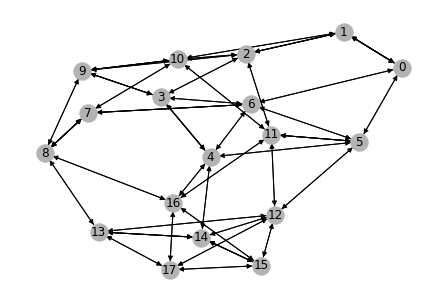

In [8]:
# take the first graph as an example
plot_graph(graphs[0])

So for this particular jet, there are 18 constituents

### Prepare dataset for training, validation and test

- We will split the data into training, validation and test dataset according to the ratios 0.6:0.2:0.2

In [9]:
train_size = int(len(graphs) * 0.6)
val_size = int(len(graphs) * 0.2)
test_size = len(graphs) - train_size - val_size

dataset = list(zip(graphs, y['label']))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, val_size, test_size))

# since the training is very slow, just let batch size be 1
train_dataloader = dgl.dataloading.GraphDataLoader(train_dataset, batch_size = train_size, drop_last=False, shuffle=True)
val_dataloader = dgl.dataloading.GraphDataLoader(val_dataset, batch_size = val_size, drop_last=False, shuffle=False)
test_dataloader = dgl.dataloading.GraphDataLoader(test_dataset, batch_size = test_size, drop_last=False, shuffle=False)

print('Train size: ', train_size)
print('Validation size: ', val_size)
print('Test size: ', test_size)

Train size:  60000
Validation size:  20000
Test size:  20000


# 3. Implementing Graph Neural Network Models

Suppose we have a graph $G$ with $n$ nodes and $m$ edges. We have\
$X$ is the feature matix for the nodes\
$A$ is the adjacency matrix of the graph $G$\
$\tilde{A}=A+I_n$ is the adjacency matrix with added self-loops\
$\tilde{D}_{ij} = \sum_{k} \tilde{A}_{ik}\delta_{ij}$ is the diagonal degree matrix\
$\mathcal{N}$ is the neighborhood function\
$W$ is the weight matrix

The essence of a GNN architecture is in its node representation $H^K$ where $K$ is the depth/iteraction. 

Here , a total of 5 GNN architectures is implemented using the popular `dgl` libraries. 

- **SGC** (Simplifying Graph Convolution) layer (https://arxiv.org/pdf/1902.07153.pdf): \
$H^K = (\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2})^KX\Theta$\
where $\Theta$ is a learned weight matrix\

- **SAGE** (SAmple and aggreGatE) convolution layer (https://arxiv.org/pdf/1706.02216.pdf): \
$H^{\ell+1}_{\mathcal{N}(i)} = \text{aggregate}(\{H_j^\ell,\forall j\in \mathcal{N}(i)\})$\
where $\text{aggregate}$ is a differentiable aggregator function\
Here the `mean` aggregator is used.

- **GAT** (Graph Attention Network) (https://arxiv.org/pdf/1710.10903.pdf): \
$H^{\ell+1}_i = \sum_{j\in \mathcal{N}(i)}\alpha_{i,j}W^{(\ell)}H_j^{\ell}$\
where $\alpha_{i,j}$ is the attention score bewteen node $i$ and node $j$:\
$\alpha_{ij}^{l} = \mathrm{softmax_i} (e_{ij}^{l})$\
$e_{ij}^{l} = \mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)$

- **AGNN** (Attention-based Graph Neural Network) convolution layer (https://arxiv.org/abs/1803.03735): \
$H^{l+1} = P H^{l}$\
$P_{ij} = \mathrm{softmax}_i ( \beta \cdot \cos(h_i^l, h_j^l))$\
where $\beta$ is a single scalar parameter.

- **GCN** (Graph Convolutional Network) (https://arxiv.org/abs/1609.02907): \
$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$\
where $\sigma$ is an activation function


In [10]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
from dgl.nn.pytorch.conv import GraphConv


class SGC(nn.Module):
    ''' 
        https://docs.dgl.ai/api/python/nn.pytorch.html?highlight=sageconv#sgconv
    '''
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SGConv(in_feats=in_feats, out_feats=hid_feats)
        self.conv2 = dglnn.SGConv(in_feats=hid_feats, out_feats=out_feats)

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.elu(h)
        h = self.conv2(graph, h)
        h = torch.sigmoid(h)
        return h

class SAGE(nn.Module):
    ''' Two layers of Inductive Representation Learning on Large Graphs.
        https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv
    '''
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.elu(h)
        h = self.conv2(graph, h)
        h = torch.sigmoid(h)
        return h

class GAT(nn.Module):
    ''' Two layers of Graph Attention Network.
        https://docs.dgl.ai/api/python/nn.pytorch.html#gatconv
    '''
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        # input shape = (nodes, features=in_feats); output shape = (nodes, num_head, hid_feats)
        self.gatconv1 = dglnn.GATConv(in_feats, hid_feats, num_heads=2)
        # input shape = (nodes, hid_feats * num_heads_previous_layer); output shape = (nodes, num_head, out_feats)
        self.gatconv2 = dglnn.GATConv(hid_feats * 2, out_feats, num_heads=1)

    def forward(self, graph, inputs):
        # input shape = (nodes , features)
        # print('inputs', inputs.shape, inputs)
        h = self.gatconv1(graph, inputs)
        # here h shape = (nodes, num_head, hid_feats)
        # print('h1', h.shape, h)
        ''' Reshape h to flatten the num_heads '''
        # here h shape = (nodes, num_head * hid_feats)
        h = h.reshape(h.shape[0], np.prod(h.shape[1:]))
        # print('h2', h.shape, h)
        h = self.gatconv2(graph, h)
        # print('h3', h.shape, h)

        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        # print('h4', h.shape, h)
        h = torch.sigmoid(h)
        h = torch.squeeze(h)
        # print('h9', h.shape, h)
        return h

class AGNNConv(nn.Module):
    ''' Graph Attention Network.
        https://docs.dgl.ai/api/python/nn.pytorch.html#agnnconv
    '''
    def __init__(self):
        super().__init__()

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = AGNNConv()(graph, inputs)
        h = torch.sigmoid(h)
        return h

class GCN(nn.Module):
    ''' Graph Convolutional Network
        https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html#graph-classification-tutorial
        https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/1_gcn.html
    '''
    def __init__(self, in_dim, hidden_dim, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, out_feats)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_dim)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_dim)
        self.bn3 = nn.BatchNorm1d(num_features=out_feats)

    def forward(self, graph, h):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        # h = graph.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.bn1(self.conv1(graph, h)))
        h = F.relu(self.bn2(self.conv2(graph, h)))
        h = F.relu(self.bn3(self.conv3(graph, h)))
        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        # Calculate graph representation by averaging all the node representations.
        h = torch.sigmoid(h)
        h = (h-0.5) * 2
        return h

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class GNNmodel(nn.Module):
    def __init__(self, module, in_features, hidden_features, out_features, name='GNN'):
        super().__init__()
        
        self.name = name

        if module.lower() == 'sage':
            # from dgl.nn import SAGEConv
            self.module = SAGE(in_features, hidden_features, out_features)
        elif module.lower() == 'gat':
            # from dgl.nn import GATConv
            self.module = GAT(in_features, hidden_features, out_features)
        elif module.lower() == 'agnnconv':
            # from dgl.nn import AGNNConv
            self.module = AGNNConv()
        elif module.lower() == 'sgc':
            # from dgl.nn import SGConv
            self.module = SGC(in_features, hidden_features, out_features)
        elif module.lower() == 'gcn':
            self.module = GCN(in_features, hidden_features, out_features)
        else:
            assert False, module + ' is not supported'

        # self.pred = MLPPredictor(out_features, 1)

    def forward(self, g, x):
        h = self.module(g, x)
        return torch.squeeze(h) #self.pred(g, h)

In [11]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



In [12]:
# define training loop
def train(model, optimizer, epochs=100, loss_func=nn.MSELoss()):
  epoch_losses = {'train': [], 'val': []}
  for epoch in range(epochs):
      train_loss = 0
      for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
          node_features = batched_graph.ndata['feature']
          pred = model(batched_graph, node_features.float())
          loss = loss_func(pred, labels.float())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.detach().item()

      # The loss per epoch for all batch is the average of losses per batch in this epoch 
      train_loss /= (ibatch + 1)

      # Store loss per epoch 
      epoch_losses['train'].append(train_loss)

      # Evaluate validation loss
      for ibatch, (batched_graph, labels) in enumerate(val_dataloader):
          node_features = batched_graph.ndata['feature']
          pred = model(batched_graph, node_features.float())
          val_loss = loss_func(pred, labels.float()).detach().item()
          epoch_losses['val'].append(val_loss)
          assert(ibatch == 0)

      print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mepoch, loss, val_loss:\033[0m'.rjust(40, ' '),  epoch+1, '|', train_loss, '|', val_loss)

      # Early stopping
      early_stopping = EarlyStopping(patience=10, verbose=False, path='{}.checkpoint'.format(model.name))
      # early_stopping needs the validation loss to check if it is decreasing, 
      # and if it is, it will make a checkpoint of the current model
      early_stopping(val_loss, model)

      if early_stopping.early_stop:
          print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mepoch, loss, val_loss:\033[0m'.rjust(40, ' '),  epoch+1, '|', train_loss, '|', val_loss)
          print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mEarly stop at:\033[0m'.rjust(40, ' '),  epoch)
          break
  return epoch_losses

## Architecture 1: Graph Attention Network

In [13]:
hidden_features, out_features = 9, 1 # 2 = classifier predict
torch.manual_seed(0)
# create the model
gat_model = GNNmodel('GAT', graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features, name='GAT')
print('Node feature dimension evolution {}->{}->{}'.format(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features))

Node feature dimension evolution 4->9->1


### Start Training

In [14]:
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.1)

In [15]:
losses = train(gat_model, optimizer)

2021-03-24 20:28:30 [INFO]          epoch, loss, val_loss: 1 | 0.25052410364151 | 0.24799008667469025
2021-03-24 20:28:41 [INFO]          epoch, loss, val_loss: 2 | 0.24802954494953156 | 0.2457846850156784
2021-03-24 20:28:53 [INFO]          epoch, loss, val_loss: 3 | 0.24580667912960052 | 0.24166716635227203
2021-03-24 20:29:05 [INFO]          epoch, loss, val_loss: 4 | 0.24158447980880737 | 0.23618681728839874
2021-03-24 20:29:17 [INFO]          epoch, loss, val_loss: 5 | 0.23592235147953033 | 0.22967109084129333
2021-03-24 20:29:29 [INFO]          epoch, loss, val_loss: 6 | 0.22918473184108734 | 0.22129979729652405
2021-03-24 20:29:40 [INFO]          epoch, loss, val_loss: 7 | 0.22062121331691742 | 0.2115376740694046
2021-03-24 20:29:52 [INFO]          epoch, loss, val_loss: 8 | 0.21066485345363617 | 0.20173482596874237
2021-03-24 20:30:04 [INFO]          epoch, loss, val_loss: 9 | 0.20066194236278534 | 0.19311577081680298
2021-03-24 20:30:16 [INFO]          epoch, loss, val_loss: 1

In [17]:
# load the last checkpoint with the best model.
gat_model.load_state_dict(torch.load(gat_model.name+'.checkpoint'))
# save the model
torch.save(gat_model, gat_model.name)

### Test the model

In [18]:
 def test(model, loss_func=nn.MSELoss()):
    epoch_losses = {'test': []}
    with torch.no_grad():
        ''' Final Evaluate train loss '''
        train_pred = []
        train_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            # print('zhangr train pred', pred.shape, pred)
            # print('zhangr train labels', labels.shape, labels)
            train_pred.append(pred)
            train_labels.append(labels)
        train_pred = torch.cat(train_pred).numpy()
        train_labels = torch.cat(train_labels).numpy()

        ''' Final Evaluate val loss '''
        val_pred = []
        val_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            val_pred.append(pred)
            val_labels.append(labels)
            assert(ibatch == 0)
        val_pred = torch.cat(val_pred).numpy()
        val_labels = torch.cat(val_labels).numpy()


        ''' Evaluate test loss '''
        test_pred = []
        test_labels = []
        for ibatch, (batched_graph, labels) in enumerate(test_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            test_loss = loss_func(pred, labels.float()).detach().item()
            epoch_losses['test'].append(test_loss)
            test_pred.append(pred)
            test_labels.append(labels)
            assert(ibatch == 0)
        test_pred = torch.cat(test_pred).numpy()
        test_labels = torch.cat(test_labels).numpy()
    return epoch_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels

In [19]:
test_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels = test(gat_model)

In [22]:
# Plot the loss over time
def plot_loss(*losses, labels=None):
    plt.clf()
    fig = plt.figure(figsize=(10, 5))
    for loss in losses:
        plt.plot(loss)
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    if labels:
      plt.legend(labels, loc='upper right', fontsize=15)
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

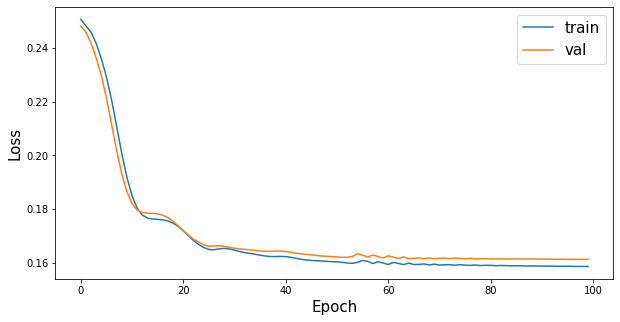

In [23]:
plot_loss(losses['train'], losses['val'], labels=['train', 'val'])

In [24]:
# Plot the ROC curve
# this is taken from my own package `quple`
from typing import List
def plot_stacked_roc_curve(fpr_list:List[np.ndarray], 
                   tpr_list:List[np.ndarray], labels:List[str]=None, title:str='ROC Curve', with_auc:bool=True):
    """Plots multiple roc curves stacked together
    
    Args:
        fpr: list/array of numpy array
            A collection of arrays containing the false positive rates for 
            different experiments
        tpr: list/array of numpy array
            A collection of arrays containing the false positive rates for 
            different experiments
        labels: list of str, default = None
            List of labels for different experiments.
        title: str, default = 'ROC Curve'
            Title of the plot
        with_auc: True or False
            Whether to include the auc in the labels

    Returns:
        A matplotlib plot of the stacked roc curve
    """     
    assert len(fpr_list) == len(tpr_list)
    n = len(fpr_list)
    if labels is None:
        labels = ['']*n
    assert len(labels) == n
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    plt.clf()
    plt.rcParams["font.weight"] = "bold"
    plt.xlabel("Signal Efficiency", fontsize=18,fontweight='bold')
    plt.ylabel("Background Rejection", fontsize=18,fontweight='bold')
    plt.title(title, fontsize=16,fontweight='bold')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.grid(color='gray', linestyle='--', linewidth=1)  
    for fpr,tpr,label in zip(fpr_list, tpr_list, labels):
        if with_auc:
            roc_auc = auc(fpr, tpr)
            label += ', AUC={:.4f}'.format(roc_auc)
        plt.plot(tpr,1-fpr, linestyle='-',label=label,linewidth=2)
    plt.plot([0, 1], [1, 0], linestyle='--', color='black', label='Luck, AUC= 0.5')
    plt.legend(loc='best',prop={'size': 8})    
    return plt       


def plot_roc_curve(fpr:np.ndarray, tpr:np.ndarray, label:str='', title:str='ROC Curve', with_auc:bool=True):
    """Plots a roc curve
    
    Args:
        fpr: numpy array
            An array containing the false positive rates
        tpr: numpy array
            An array containing the true positive rates
        label: str
            Label of the curve
        title: str
            Title of the plot
        with_auc: True or False
            Whether to include the auc in the labels
    
    Returns:
        A matplotlib plot of the roc curve
    """        
    return plot_stacked_roc_curve([fpr], [tpr], [label], title=title, with_auc=with_auc)  

In [25]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, _ = roc_curve(train_labels, train_pred)
val_fpr, val_tpr, _ = roc_curve(val_labels, val_pred)
test_fpr, test_tpr, _ = roc_curve(test_labels, test_pred)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

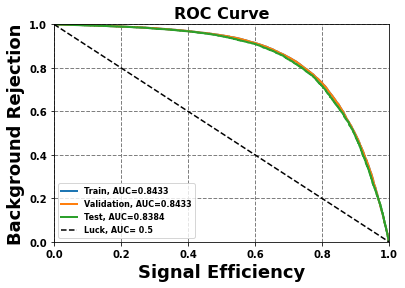

In [26]:
plot_stacked_roc_curve([train_fpr, val_fpr, test_fpr], [train_tpr, val_tpr, test_tpr], labels=['Train', 'Validation', 'Test'])

## Architecture 2: Graph Convolution Network

In [28]:
hidden_features, out_features = 9, 1 # 2 = classifier predict
torch.manual_seed(0)
# create the model
gcn_model = GNNmodel('GCN', graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features, name='GAT')
print('Node feature dimension evolution {}->{}->{}'.format(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features))

Node feature dimension evolution 4->9->1


### Start Training

In [30]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.1)

In [31]:
losses_2 = train(gcn_model, optimizer)

2021-03-24 20:55:23 [INFO]          epoch, loss, val_loss: 1 | 0.3448742628097534 | 0.2813892960548401
2021-03-24 20:55:33 [INFO]          epoch, loss, val_loss: 2 | 0.2811126708984375 | 0.21414700150489807
2021-03-24 20:55:43 [INFO]          epoch, loss, val_loss: 3 | 0.21329431235790253 | 0.19428750872612
2021-03-24 20:55:52 [INFO]          epoch, loss, val_loss: 4 | 0.19374191761016846 | 0.18259280920028687
2021-03-24 20:56:01 [INFO]          epoch, loss, val_loss: 5 | 0.18221718072891235 | 0.17261870205402374
2021-03-24 20:56:10 [INFO]          epoch, loss, val_loss: 6 | 0.17212820053100586 | 0.1660073697566986
2021-03-24 20:56:20 [INFO]          epoch, loss, val_loss: 7 | 0.16527646780014038 | 0.16197234392166138
2021-03-24 20:56:29 [INFO]          epoch, loss, val_loss: 8 | 0.16106577217578888 | 0.15981940925121307
2021-03-24 20:56:38 [INFO]          epoch, loss, val_loss: 9 | 0.1587996482849121 | 0.15880434215068817
2021-03-24 20:56:47 [INFO]          epoch, loss, val_loss: 10 |

In [32]:
# load the last checkpoint with the best model.
gcn_model.load_state_dict(torch.load(gcn_model.name+'.checkpoint'))
# save the model
torch.save(gcn_model, gcn_model.name)

### Test the model

In [34]:
test_losses2, train_pred2, train_labels2, val_pred2, val_labels2, test_pred2, test_labels2 = test(gcn_model)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

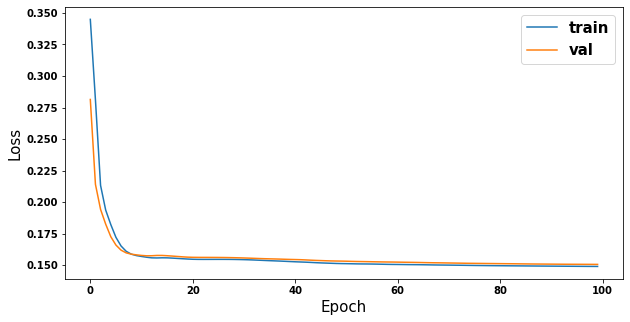

In [35]:
plot_loss(losses_2['train'], losses_2['val'], labels=['train', 'val'])

In [36]:
from sklearn.metrics import roc_curve, auc
train_fpr2, train_tpr2, _ = roc_curve(train_labels2, train_pred2)
val_fpr2, val_tpr2, _ = roc_curve(val_labels2, val_pred2)
test_fpr2, test_tpr2, _ = roc_curve(test_labels2, test_pred2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

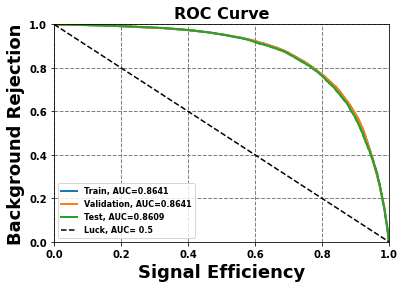

In [37]:
plot_stacked_roc_curve([train_fpr2, val_fpr2, test_fpr2], [train_tpr2, val_tpr2, test_tpr2], labels=['Train', 'Validation', 'Test'])

So we just tried two different GNN architectures:
1. Two layers of Graph Attention Network (GAT)
2. Three layers of Graph Convolution Network (GCN)

These architectures are quite well know in the GNN domain, while the number of layer is arbitrarily chosen.

Without much tuning on the hyperparameters for both cases, it is clear that the networks have quite good separation power, in particular the GCN.

The AUC in the original paper (https://arxiv.org/abs/1810.05165) for the dataset is around 0.9 (Table 3), whereas the GCN gives 0.864. So, there are still rooms to improve.

Here we only used one of the training dataset is only 1 file from the linked original files. Using more training jets could improve the performance.

No obvious overtraining is seen from the loss values and from the ROC and Response plots.